# Proyek Sistem Rekomendasi: [Input Nama Dataset]
- **Nama:** [Maulidhan Ady Nugraha]
- **Email:** [maulidhan6@gmail.com]
- **Username Dicoding:** [maulidhanadynugraha]

## Import Semua Packages/Library

mengimport semua library yang dibutuhkan

In [2]:
import os
import pandas as pd
import kagglehub
import numpy as np
import zipfile
import json

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

## Data Preparation

### Data Loading

load data dari kaglle link sebagai berikut [data_netflix](https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset)

In [3]:
# Download latest version
path = kagglehub.dataset_download("rishitjavia/netflix-movie-rating-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rishitjavia/netflix-movie-rating-dataset/versions/1


membaca data yang telah diload

In [4]:
# Get the list of files in the downloaded directory
files = os.listdir(path)

# Print the list of files
path_list_film=files[0]
path_list_rating = files[1]

# Construct the full path to the CSV file
file_path_list_rating = os.path.join(path, path_list_rating)
file_path_list_film = os.path.join(path, path_list_film)

membuat dataframe dari data rating film netflix

In [5]:
# Read the CSV file
df = pd.read_csv(file_path_list_rating)

#### Cek Informasi Data

menampilkan data

In [6]:
df

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3
...,...,...,...
17337453,520675,3,4496
17337454,1055714,5,4496
17337455,2643029,4,4496
17337456,1559566,3,4496


mengecek apakah ada data yang kosong

In [7]:
df.isnull().sum()

,0
User_ID,0
Rating,0
Movie_ID,0


melihat berapa user yang ada

In [8]:
pd.Series(df["User_ID"].unique()).sort_values() #Convert to pandas Series then sort

,0
89528,6
6079,7
69871,79
112471,97
43258,134
...,...
138638,2649370
33264,2649378
74245,2649388
14543,2649426


#### Seleksi User

meneyeleksi user yang sudah merating lebih dari 400 film

In [9]:
user_rating_counts = df.groupby('User_ID')['Rating'].count()
users = user_rating_counts[user_rating_counts >= 400]
users

,Rating
User_ID,
1333,611
3321,688
3998,487
4905,410
10268,548
...,...
2640760,468
2645579,583
2646347,416


membuat data frame dari user yang sudah diseleksi

In [10]:
selected_df = df[df['User_ID'].isin(users.index)]
selected_df

,User_ID,Rating,Movie_ID
28,603277,3,3
45,2312349,4,3
51,1977959,4,3
66,1333,4,3
92,2554745,4,3
...,...,...,...
17337391,2634967,1,4496
17337398,1300759,4,4496
17337433,2513621,4,4496
17337434,324510,3,4496


menegcek jumlah user setelah proses seleksi

In [11]:
pd.Series(selected_df["User_ID"].unique()).sort_values() #Convert to pandas Series then sort

,0
3,1333
282,3321
1026,3998
1401,4905
1124,10268
...,...
587,2640760
1237,2645579
1106,2646347
1295,2646574


melihat jumlah film

In [12]:
pd.Series(selected_df["Movie_ID"].unique()).sort_values() #Convert to pandas Series then sort

,0
0,3
1,8
2,16
3,17
4,18
...,...
1345,4488
1346,4490
1347,4492
1348,4493


#### Sparsity

Persentase sparsity yang menjadi masalah dalam sistem rekomendasi

In [13]:
maksimum_jumlah_rating = len(selected_df["User_ID"].unique()) * len(selected_df["Movie_ID"].unique())
missing_value=maksimum_jumlah_rating-selected_df["Rating"].count()
sparsity=missing_value/maksimum_jumlah_rating*100

print("Maksimum jumlah rating:",maksimum_jumlah_rating)
print("Jumlah rating:",selected_df["Rating"].count())
print("Jumlah data yang kosong:",missing_value)
print("Sparsity:",round(sparsity, 2),"%")

Maksimum jumlah rating: 2335500
Jumlah rating: 858970
Jumlah data yang kosong: 1476530
Sparsity: 63.22 %


### Data Preprocessing

#### Split Dataset

Melakukan split data 80% training, 20% testing

In [14]:
from sklearn.model_selection import train_test_split
# Split data (80% training, 20% testing)
train_data, test_data = train_test_split(selected_df, test_size=0.2, random_state=42)

print("Training Data:\n", train_data)
print("\nTesting Data:\n", test_data)

Training Data:
           User_ID  Rating  Movie_ID
6366288   1999678       5      1746
14584994   838130       3      3858
13499111  1675966       4      3579
1723249    934606       4       452
1481411   1247574       2       361
...           ...     ...       ...
5094265   2580072       3      1408
7223252   1559165       4      1956
2638021   1672832       2       700
13304311  1784150       3      3523
2520326   2407453       5       660

[687176 rows x 3 columns]

Testing Data:
           User_ID  Rating  Movie_ID
4270669   2602249       3      1160
16015123  1494162       3      4216
2814222   1181609       4       746
15064749   423990       5      3925
16641672    10947       3      4345
...           ...     ...       ...
12153013    53694       3      3265
16501147   394895       4      4310
2111102   2360906       2       548
5600387    977932       5      1561
11469945  2025153       3      3095

[171794 rows x 3 columns]


## Modelling

membuat matriks dari data training

In [15]:
# Membuat matriks pengguna-item
matrix = train_data.pivot_table(index='User_ID', columns='Movie_ID', values='Rating', fill_value=0)

menampilkan matriks data training

In [16]:
matrix

Movie_ID,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
User_ID,,,,,,,,,,,,,,,,,,,,,
1333,4.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0,2.0
3321,0.0,0.0,3.0,2.0,0.0,0.0,4.0,5.0,2.0,0.0,...,2.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,3.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4905,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,...,4.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0
10268,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640760,0.0,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,...,3.0,1.0,0.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0
2645579,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,3.0,0.0,2.0,3.0,0.0
2646347,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0


menyeleksi hanya nilai rating saja yang digunakan

In [17]:
R= matrix.values

menampilkan matrikx nilai rating

In [18]:
R

array([[4., 3., 0., ..., 0., 0., 2.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

#### SVD

melakukan svd dengan menggunakan n_components=50

In [19]:
# Truncated SVD
svd = TruncatedSVD(n_components=50)  # 2 komponen laten

Menghitung matriks U (merepresentasikan laten user)

In [20]:
U = svd.fit_transform(R)

Menghitung matriks Vt

In [21]:
# Matriks V^T tereduksi
Vt = svd.components_

menampilkan ukuran matriks U

In [22]:
U.shape

(1730, 50)

Menampilkan ukuran matriks Vt

In [23]:
Vt.shape

(50, 1350)

Mengkalikan matrik U dengan matriks Vt

In [24]:
R_pred = np.dot(U, Vt)

# Menampilkan matriks rating yang diprediksi
print("Matriks rating yang diprediksi:")
print(R_pred)

Matriks rating yang diprediksi:
[[ 1.66664489  1.63845022  0.15437824 ...  0.16454658  0.86447258
   3.11977926]
 [ 0.09348413  0.31188086  1.68823337 ...  1.11070696  0.59964196
   0.13492933]
 [ 0.16181427  0.02332605  1.41816688 ...  1.17302345  0.3050499
  -0.13558964]
 ...
 [ 0.08021554  0.20424761 -0.19269774 ... -0.10454467  0.35930923
   1.25796316]
 [ 0.05368339  0.04191204  0.11524647 ...  0.68058653  1.08286003
   0.67975735]
 [ 0.31188799  0.64796775  1.59004717 ...  1.41711096  0.19000367
  -0.53367025]]


#### UB

mencari user similarity dari matrik U

In [25]:
# Menghitung similarity antar pengguna menggunakan cosine similarity
user_similarity = cosine_similarity(U)

# Menampilkan similarity antar pengguna
print("User-User Similarity Matrix:")
print(user_similarity)

User-User Similarity Matrix:
[[1.         0.55627508 0.51852319 ... 0.59154549 0.63447471 0.50736459]
 [0.55627508 1.         0.83232445 ... 0.69245999 0.80098544 0.81027741]
 [0.51852319 0.83232445 1.         ... 0.65008785 0.7477825  0.78527051]
 ...
 [0.59154549 0.69245999 0.65008785 ... 1.         0.63130502 0.60589835]
 [0.63447471 0.80098544 0.7477825  ... 0.63130502 1.         0.7573695 ]
 [0.50736459 0.81027741 0.78527051 ... 0.60589835 0.7573695  1.        ]]


menampilkan ukuran matriks user similarity

In [26]:
user_similarity.shape

(1730, 1730)

Menyimpan matriks

In [27]:
# Menyimpan ke file .npy
np.save("U.npy", U)
np.save("Vt.npy", Vt)
np.save("R_pred.npy", R_pred)
np.save("user_similarity.npy", user_similarity)

Membuat sebuah rekomendasi

In [28]:
# Fungsi untuk memberikan rekomendasi berdasarkan pengguna yang mirip
def get_recommendations(user_idx, user_similarity, R_pred, top_n=10):
    # Mendapatkan similarity pengguna dengan pengguna lainnya
    similar_users = user_similarity[user_idx]

    # Menghitung weighted average untuk prediksi rating berdasarkan pengguna yang mirip
    weighted_ratings = np.dot(similar_users, R_pred) / np.sum(np.abs(similar_users))

    # Mengambil top-n rekomendasi untuk pengguna
    recommended_items = np.argsort(weighted_ratings)[::-1][:top_n]

    return recommended_items, weighted_ratings[recommended_items]

Menghitung NDCG

In [29]:
# Fungsi untuk menghitung DCG dan NDCG
def dcg_at_k(ranking, k):
    """
    Menghitung DCG pada posisi k untuk sebuah ranking.
    ranking: array yang berisi relevansi (rating aktual) item yang direkomendasikan.
    k: jumlah top item yang digunakan.
    """
    ranking = ranking[:k]
    dcg = np.sum(ranking / np.log2(np.arange(2, k + 2)))
    return dcg

def ndcg_at_k(ranking, ideal_ranking, k):
    """
    Menghitung NDCG pada posisi k dengan membandingkan ranking yang diperoleh dan ranking ideal.
    ranking: array yang berisi relevansi (rating aktual) item yang direkomendasikan.
    ideal_ranking: array yang berisi rating aktual item yang diurutkan berdasarkan relevansi tertinggi.
    k: jumlah top item yang digunakan.
    """
    dcg = dcg_at_k(ranking, k)
    idcg = dcg_at_k(ideal_ranking, k)
    return dcg / idcg if idcg > 0 else 0

Meinisiasi recomendation dan ndcg dengan mengambil top 10

In [30]:
# Menghitung rekomendasi dan NDCG untuk semua pengguna
top_n = 10  # Mengambil 10 rekomendasi teratas
recommendations = {}
ndcg_scores = {}

Menjalankan fungsi rekomendasi dan NDCG

In [31]:
for user_idx in range(R.shape[0]):  # Iterasi untuk setiap pengguna
    recommended_items, predicted_ratings = get_recommendations(user_idx, user_similarity, R_pred, top_n)

    # Rating aktual untuk item yang direkomendasikan (dari R asli)
    actual_ratings = R[user_idx, recommended_items]

    # Ideal ranking adalah rating yang terurut secara menurun
    ideal_ranking = np.sort(actual_ratings)[::-1]

    # Menghitung NDCG untuk pengguna tersebut
    ndcg_score = ndcg_at_k(actual_ratings, ideal_ranking, top_n)

    # Simpan rekomendasi dan NDCG untuk pengguna
    recommendations[user_idx] = {
        "recommended_items": recommended_items.tolist(),
        "predicted_ratings": predicted_ratings.tolist()
    }
    ndcg_scores[user_idx] = ndcg_score

Menyimpan file

In [32]:
# Menyimpan ke file .npy
np.save("recommendations.npy", recommendations)
np.save("ndcg_scores.npy", ndcg_scores)

### UB Tanpa SVD

Menghitung similarity tanpa SVD

In [33]:
# Menghitung cosine similarity antar pengguna
user_similarity = cosine_similarity(matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=matrix.index, columns=matrix.index)


Fungsi Prediksi

In [34]:
# Fungsi untuk menghitung prediksi rating
def predict_ratings_all_users(matrix, user_similarity_df):
    recommendations = {}
    for user in matrix.index:
        user_ratings = matrix.loc[user]
        sim_scores = user_similarity_df.loc[user]

        # Hanya hitung untuk film yang belum diberi rating
        unrated_films = user_ratings[user_ratings == 0].index
        predicted_ratings = {}

        for film in unrated_films:
            # Ambil rating semua pengguna untuk film ini
            film_ratings = matrix[film]
            numerator = np.dot(sim_scores, film_ratings)
            denominator = np.abs(sim_scores).sum()
            predicted_ratings[film] = numerator / denominator if denominator != 0 else 0

        recommendations[user] = predicted_ratings
    return recommendations


Fungsi untuk menghitung NDCG

In [35]:
# Fungsi untuk menghitung NDCG@top_n
def calculate_ndcg_top_n(user, recommendations, matrix, top_n=10):
    actual_ratings = matrix.loc[user]  # Rating sebenarnya
    pred_ratings = recommendations[user]  # Rating prediksi

    # Urutkan berdasarkan prediksi (ambil top-n)
    sorted_pred = sorted(pred_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]
    sorted_actual = sorted(actual_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # DCG untuk top-n
    dcg = 0
    for i, (film, pred) in enumerate(sorted_pred):
        relevance = actual_ratings.get(film, 0)
        dcg += relevance / np.log2(i + 2)  # log2(i + 1) + 1 to avoid division by zero

    # IDCG (ideal DCG) untuk top-n
    idcg = 0
    for i, (film, actual) in enumerate(sorted_actual):
        relevance = actual_ratings.get(film, 0)
        idcg += relevance / np.log2(i + 2)

    ndcg = dcg / idcg if idcg > 0 else 0
    return ndcg

Memperoleh semua rekomendasi

In [36]:
# Menghitung rekomendasi untuk semua pengguna
all_recommendations = predict_ratings_all_users(matrix, user_similarity_df)

Menghitung NDCG

In [37]:
# Menghitung NDCG@top_n untuk semua pengguna
top_n = 10
ndcg_scores_top_n = {}
for user in matrix.index:
    ndcg_scores_top_n[user] = calculate_ndcg_top_n(user, all_recommendations, matrix, top_n=top_n)

# Menyimpan hasil rekomendasi dan NDCG@top_n ke file .npy
np.save("recommendations_tanpa_svd.npy", all_recommendations)
np.save("ndcg_scores_tanpa_svd.npy", ndcg_scores_top_n)

## Evaluasi dan Visualisasi

Menampilkan hasil perbandingan NDCG dengan menggunakan SVD dan tanpa menggunakan SVD

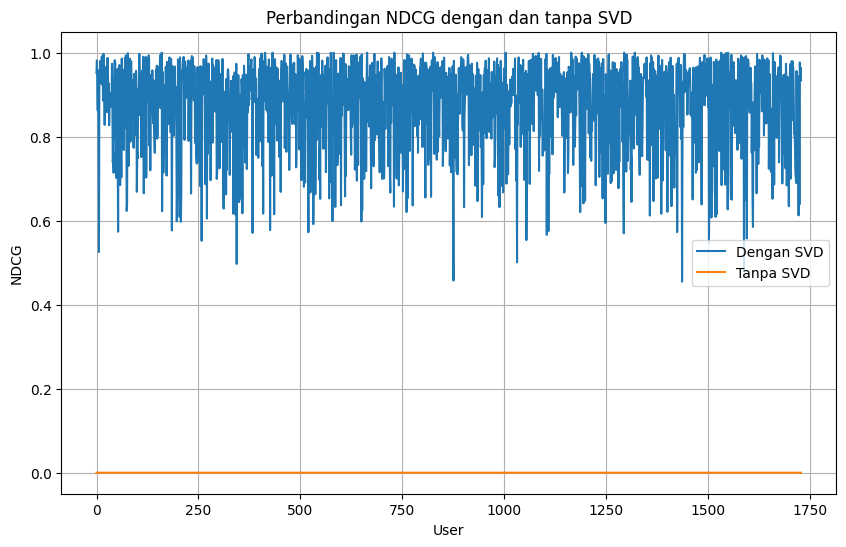

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Load NDCG scores
ndcg_scores = np.load('ndcg_scores.npy', allow_pickle=True).item()
ndcg_scores_top_n = np.load('ndcg_scores_tanpa_svd.npy', allow_pickle=True).item()

# Extract NDCG values
ndcg_values = list(ndcg_scores.values())
ndcg_top_n_values = list(ndcg_scores_top_n.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(ndcg_values)), ndcg_values, label='Dengan SVD')
plt.plot(range(len(ndcg_top_n_values)), ndcg_top_n_values, label='Tanpa SVD')
plt.xlabel('User')
plt.ylabel('NDCG')
plt.title('Perbandingan NDCG dengan dan tanpa SVD')
plt.legend()
plt.grid(True)
plt.show()

## Inference

Membuat dataframe list film

In [40]:
df_list_film = pd.read_csv(file_path_list_film)

menampilkan list film

In [41]:
df_list_film

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


Membandingkan perbandingan hasil rekomendasi dari yang menggunakan SVD dan tanpa menggunakan SVD

In [42]:
# Memuat data yang diperlukan
recommendations = np.load('recommendations.npy', allow_pickle=True).item()  # Memuat rekomendasi dengan SVD
all_recommendations = np.load('recommendations_tanpa_svd.npy', allow_pickle=True).item()  # Memuat rekomendasi tanpa SVD
matrix = pd.read_csv(file_path_list_rating).pivot_table(index='User_ID', columns='Movie_ID', values='Rating', fill_value=0)  # Membuat matriks user-item
movies = pd.read_csv(file_path_list_film)  # Memuat daftar film

# Fungsi untuk mendapatkan judul film berdasarkan ID film
def get_movie_titles(movie_ids, movies_df):
    return movies_df[movies_df['Movie_ID'].isin(movie_ids)]['Name'].tolist()

# Input User ID
user_id_input = 1333  # ID pengguna yang ingin dicek rekomendasinya

# Mencari indeks pengguna pada matriks
try:
    user_index = matrix.index.get_loc(user_id_input)  # Mendapatkan indeks pengguna dari User_ID
except KeyError:
    print(f"User ID {user_id_input} tidak ditemukan.")  # Pesan jika User_ID tidak ditemukan
    exit()

# Mendapatkan rekomendasi untuk pengguna yang ditentukan (dengan dan tanpa SVD)
top_n = 10  # Jumlah rekomendasi teratas yang diinginkan

# Rekomendasi dengan SVD
if user_index in recommendations:
    recommended_items_svd = recommendations[user_index]['recommended_items']  # Film yang direkomendasikan
    movie_titles_svd = get_movie_titles(recommended_items_svd, movies)  # Mendapatkan judul film dari ID
    print(f"\nRekomendasi dengan SVD untuk User ID {user_id_input}:")
    for i, title in enumerate(movie_titles_svd):
        print(f"{i + 1}. {title}")  # Menampilkan rekomendasi satu per satu
else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk User ID {user_id_input} dengan SVD.")

# Rekomendasi tanpa SVD
if user_id_input in all_recommendations:
    # Mengurutkan rekomendasi berdasarkan rating prediksi (top-N)
    recommended_items_no_svd = sorted(all_recommendations[user_id_input].items(), key=lambda x: x[1], reverse=True)[:top_n]
    movie_ids_no_svd = [movie_id for movie_id, _ in recommended_items_no_svd]  # Mengambil ID film
    movie_titles_no_svd = get_movie_titles(movie_ids_no_svd, movies)  # Mendapatkan judul film dari ID

    print(f"\nRekomendasi tanpa SVD untuk User ID {user_id_input}:")
    for i, title in enumerate(movie_titles_no_svd):
        print(f"{i + 1}. {title}")  # Menampilkan rekomendasi satu per satu
else:
    print(f"Tidak ada rekomendasi yang ditemukan untuk User ID {user_id_input} tanpa SVD.")


Rekomendasi dengan SVD untuk User ID 1333:
1. We're Not Married
2. Charlotte's Web
3. First Knight
4. The Scarlet and the Black
5. Domestic Disturbance
6. All in the Family: Season 3
7. The Three Stooges Go Around the World in a Daze
8. Hammer House of Horror
9. Queen of the Stardust Ballroom
10. The Twilight Zone: Vol. 19

Rekomendasi tanpa SVD untuk User ID 1333:
1. National Lampoon's Vacation
2. Aliens: Collector's Edition
3. Beverly Hills Cop
4. The Bourne Supremacy
5. Planes
6. When Harry Met Sally
7. Braveheart
8. The Godfather
9. The Matrix: Reloaded
10. Signs
